In [1]:
import torch
import math
 
import timm
from fastai.vision.all import *

if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    print("Found mps")
    default_device(torch.device("mps"))
else:
    print("Using cpu")
    default_device(torch.device("cpu"))
   

Using cpu


In [2]:
path = untar_data(URLs.MNIST)
print(path)

/Users/gwilliams/.fastai/data/mnist_png


In [3]:
block = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        get_y=parent_label)
#        batch_tfms=aug_transforms(mult=2., do_flip=False))

In [4]:
loaders = block.dataloaders(path/"training")

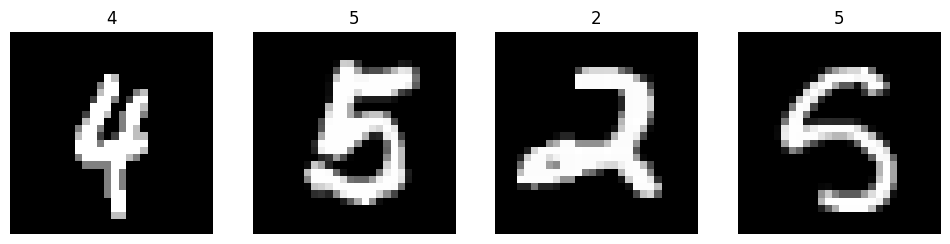

In [5]:
loaders.train.show_batch(max_n=4, nrows=1)

In [13]:
# squeezenet default fast ai learner
learn = vision_learner(loaders, squeezenet1_0, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)


<class 'torchvision.models.squeezenet.SqueezeNet'>


In [7]:
learn.summary()

Sequential (Input shape: 64 x 3 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 96 x 11 x 11   
Conv2d                                    14208      False     
ReLU                                                           
____________________________________________________________________________
                     64 x 96 x 5 x 5     
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 16 x 5 x 5     
Conv2d                                    1552       False     
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 5 x 5     
Conv2d                                    1088       False     
ReLU                                                           
Conv2d                                    9280

<class 'torch.nn.modules.container.Sequential'>


In [8]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.630520,1.301397,0.864000,01:40


In [37]:
print(type(learn.model))

<class 'torch.nn.modules.container.Sequential'>


In [43]:
pytorch_model = learn.model #.eval()
print(type(pytorch_model))

<class 'torch.nn.modules.container.Sequential'>


In [44]:
for obj in pytorch_model.state_dict():
    print(obj, 

0.0.0.weight
0.0.0.bias
0.0.3.squeeze.weight
0.0.3.squeeze.bias
0.0.3.expand1x1.weight
0.0.3.expand1x1.bias
0.0.3.expand3x3.weight
0.0.3.expand3x3.bias
0.0.4.squeeze.weight
0.0.4.squeeze.bias
0.0.4.expand1x1.weight
0.0.4.expand1x1.bias
0.0.4.expand3x3.weight
0.0.4.expand3x3.bias
0.0.5.squeeze.weight
0.0.5.squeeze.bias
0.0.5.expand1x1.weight
0.0.5.expand1x1.bias
0.0.5.expand3x3.weight
0.0.5.expand3x3.bias
0.0.7.squeeze.weight
0.0.7.squeeze.bias
0.0.7.expand1x1.weight
0.0.7.expand1x1.bias
0.0.7.expand3x3.weight
0.0.7.expand3x3.bias
0.0.8.squeeze.weight
0.0.8.squeeze.bias
0.0.8.expand1x1.weight
0.0.8.expand1x1.bias
0.0.8.expand3x3.weight
0.0.8.expand3x3.bias
0.0.9.squeeze.weight
0.0.9.squeeze.bias
0.0.9.expand1x1.weight
0.0.9.expand1x1.bias
0.0.9.expand3x3.weight
0.0.9.expand3x3.bias
0.0.10.squeeze.weight
0.0.10.squeeze.bias
0.0.10.expand1x1.weight
0.0.10.expand1x1.bias
0.0.10.expand3x3.weight
0.0.10.expand3x3.bias
0.0.12.squeeze.weight
0.0.12.squeeze.bias
0.0.12.expand1x1.weight
0.0.12.e

In [45]:
torch.save(pytorch_model, "data/fastai_mnist.pt")

In [59]:
pm = torch.load("data/fastai_mnist.pt")

In [47]:
print(type(pm))

<class 'torch.nn.modules.container.Sequential'>


In [58]:
b = loaders.one_batch()
print(len(b))
print( type(b[0]), b[0].shape)
print( type(b[1]), b[1].shape)
print( b[1][0] )
o = pm(b[0])
print( type(o), o.shape)
print(o[0])


2
<class 'fastai.torch_core.TensorImage'> torch.Size([64, 3, 28, 28])
<class 'fastai.torch_core.TensorCategory'> torch.Size([64])
TensorCategory(5)
<class 'fastai.torch_core.TensorBase'> torch.Size([64, 10])
TensorBase([-51.5757,   9.9269,   0.1997, -30.0646, -10.3557,  51.0324,
             -7.8981, -17.8561,   1.7871, -14.3553], grad_fn=<AliasBackward0>)


<class 'fastai.torch_core.TensorBase'>
